In [0]:
## Creates a tree like structure to first classify flows as either benignn or malicious 
## Then determines from which family of malware that the flow comes from. This model takes
## into account the metadata of the flow as well as the timings of packets, directions of 
## of packets, and the sequence of packet sizes. This model makes use of 4-layer Convolutional
## network with dropout. 

In [0]:
import numpy as np
import tensorflow as tf
import six 
import math
from tensorflow.python.training import moving_averages 
import pickle
import tensorflow.keras.backend as K
from sklearn.preprocessing import normalize
import tensorflow_probability as tfp
CONT_FEATURE_SIZE = 158
FINE_METADATA_SIZE = 158+512

In [0]:
def dense_logits_layer(model,input_size, output_size, drop_rate, name,train=True):
  """Fully-connected-ReLU-Batch Normalization-Dropout layer."""
  dense = tf.get_variable("weight"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[input_size,output_size]),trainable=train) 
  bias =  tf.get_variable("bias"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[output_size]),trainable=train) 

  model = tf.matmul(tf.cast(model,tf.float32), dense) + bias
  return model

In [0]:
def dense_relu_layer(model,input_size, output_size, drop_rate, name,train=True):
  """Fully-connected-ReLU-Batch Normalization-Dropout layer."""
  dense = tf.get_variable("weight"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[input_size,output_size]),trainable=train) 
  bias =  tf.get_variable("bias"+str(name),initializer =tf.random_normal(stddev=0.1, shape =[output_size]),trainable=train) 

  model =  tf.nn.relu(tf.matmul(tf.cast(model,tf.float32), dense) + bias)
  model = tf.layers.batch_normalization(model)
  model = tf.nn.dropout(x=model,rate=drop_rate)
  return model

In [0]:
## Get logits for metadata information after projecting to a given size embedding space
def get_logits_meta(x,input_shape,model_scope, name):
  with  tf.variable_scope(model_scope,reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      W_dense4_class = tf.get_variable(name+"dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[input_shape,784] ))
      b_dense4_class = tf.get_variable(name+"bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]))
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(x,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable(name+"conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]))
      conv2d_1_bias = tf.get_variable(name+"conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]))
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable(name+"conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]))
      conv2d_2_bias = tf.get_variable(name+"conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]))
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      W_dense5_class = tf.get_variable(name+"dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]))
      b_dense5_class = tf.get_variable(name+"bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]))
      out_final_logits = tf.nn.bias_add(tf.matmul(reshape_2_class, W_dense5_class),b_dense5_class)
      return out_final_logits

In [0]:
## Get logits for metadata information after projecting to 784 size embedding space
## for separating out different types of malicious trafficdef get_conv_fine_logits(x,y,return_embedding=False):
  with  tf.variable_scope("time_model",reuse=tf.AUTO_REUSE):
    with  tf.device('/device:GPU:0'):
      inp = tf.concat([x,y],axis=1)
      W_dense4_class = tf.get_variable("dense4_sec",initializer =tf.random_normal(stddev=0.1, shape =[158+512,784] ))
      b_dense4_class = tf.get_variable("bias4_sec",initializer =tf.random_normal(stddev=0.1,shape=[784]))
      h_fc4_class = tf.nn.relu(tf.matmul(tf.cast(inp,tf.float32), W_dense4_class) + b_dense4_class)

      reshape_1_class = tf.reshape(h_fc4_class,[BATCH_SHAPE,28,28,1])
      conv2d_1_weight = tf.get_variable("conv2d_1_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 1, 32]))
      conv2d_1_bias = tf.get_variable("conv2d_1_bias",initializer =tf.random_normal(stddev=0.1, shape= [32]))
      conv2d_1_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(reshape_1_class,
                                                  conv2d_1_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_1_bias))

      maxpool2d_1_class = tf.nn.max_pool(conv2d_1_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')
      conv2d_2_weight = tf.get_variable("conv2d_2_dense",initializer =tf.random_normal(stddev=0.1, shape =[5, 5, 32, 64]))
      conv2d_2_bias = tf.get_variable("conv2d_2_bias",initializer =tf.random_normal(stddev=0.1, shape=[64]))
      conv2d_2_class = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(maxpool2d_1_class,
                                                  conv2d_2_weight,
                                                  strides =[1,1,1,1],
                                                  padding='SAME'),
                                      conv2d_2_bias))

      maxpool2d_2_class = tf.nn.max_pool(conv2d_2_class,
                                       ksize=[1, 2, 2, 1], 
                                       strides=[1, 2, 2, 1],
                                padding='SAME')

      reshape_2_class = tf.reshape(maxpool2d_2_class,[BATCH_SHAPE,-1])
      drop_one = tf.nn.dropout(reshape_2_class,rate=0.2)
      W_dense5_class = tf.get_variable("dense5_sec",initializer =tf.random_normal(stddev=0.1,shape=[7*7*64,1024]))
      b_dense5_class = tf.get_variable("bias5_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024]))
      h_fc5_logit = tf.nn.bias_add(tf.matmul(drop_one, W_dense5_class),b_dense5_class)
      h_fc5_class = tf.nn.relu(h_fc5_logit)
      drop_two = tf.nn.dropout(h_fc5_class,rate=0.4)

      out_weight_class =  tf.get_variable("out_dense_sec",initializer =tf.random_normal(stddev=0.1,shape=[1024, 10]))
      out_bias_class =  tf.get_variable("out_bias_sec",initializer =tf.random_normal(stddev=0.1,shape = [10]))
      out_final_logits = tf.nn.bias_add(tf.matmul(drop_two,out_weight_class),out_bias_class)
      if return_embedding == True:
        return h_fc5_logit
      return out_final_logits

In [0]:
tf.reset_default_graph()

In [0]:
## Define input placeholders for the simple model 
with tf.device('/device:GPU:0'):
  NOISE = img_dp_noise(int(CONT_FEATURE_SIZE/2))
  ## Define the auto encoder without keras 
  x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  y_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,CONT_FEATURE_SIZE])
  
  x2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,AUTO_ENCODER_OUT_SHAPE])
  y2_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  y3_ =tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])

In [0]:
FINE_METADATA_SIZE = 1024+158
## Define input to the model
with tf.device('/device:GPU:0'):
  meta_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,METADATA_SIZE])
  fine_meta_x_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,FINE_METADATA_SIZE])
  binary_y_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,2])
  fine_y_ = tf.placeholder(tf.float32,shape= [BATCH_SHAPE,10])
  

In [0]:
## Output of binary logits 
def get_binary_logits(meta_x,name,train=True, get_embedding= False):
  logits = get_logits_meta(meta_x,158,name =name ,train=True)
  second_combined_logits = dense_relu_layer(logits,1024, 512, 0.0,name= name+ "second_logits_layer",train=train)
  combined_logits_output = dense_logits_layer(second_combined_logits, 512, 2, 0.5, name=name+ "final_binary_out",train=train)
  if get_embedding == True:
    return second_combined_logits
  return combined_logits_output

In [0]:
learning_rate = tf.placeholder(tf.float32, shape=[])

In [0]:
## First branch logits that separates malicious and benign flows
with tf.device('/device:GPU:0'):
  with  tf.variable_scope("branch_1",reuse=tf.AUTO_REUSE):
    binary_logits = get_binary_logits(meta_x_,name='branch1',train=True)
    binary_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(name="first_softmax",labels=binary_y_, logits=binary_logits))
    binary_class_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate,name="binary-adam-encoder").minimize(binary_cross_entropy)
    binary_correct_prediction = tf.equal(tf.argmax(get_binary_logits(meta_x_,name='branch1'), 1), tf.argmax(binary_y_, 1))
    binary_accuracy = tf.reduce_mean(tf.cast(binary_correct_prediction, tf.float32))

In [0]:
## Second branch of the network that outputs the type of malware
def get_fine_mal_logits(meta_x):
  embedding = get_binary_logits(meta_x_,name='branch2',train=False, get_embedding = True)
  fine_combined_logits_output = get_conv_fine_logits(embedding,meta_x)
  return fine_combined_logits_output

In [0]:
#  tf.reset_default_graph()

In [0]:
first_saver = tf.train.Saver()

In [0]:
## Second branch logits that separates different types of malicious flows
with tf.device('/device:GPU:0'):
  with  tf.variable_scope("branch_1",reuse=tf.AUTO_REUSE):
    fine_logits = get_fine_mal_logits(meta_x_)
    fine_cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(name="second_softmax",labels=fine_y_, logits=fine_logits))
    fine_class_train_step = tf.train.AdamOptimizer(learning_rate=learning_rate,name="fine-adam-encoder").minimize(fine_cross_entropy)
    fine_correct_prediction = tf.equal(tf.argmax(fine_logits, 1), tf.argmax(fine_y_, 1))
    fine_accuracy = tf.reduce_mean(tf.cast(fine_correct_prediction, tf.float32))

In [0]:
second_saver = tf.train.Saver()

In [0]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
print("GPU Available: ", tf.test.is_gpu_available())
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

GPU Available:  True
Found GPU at: /device:GPU:0


In [0]:
import numpy as np
## Load in model data
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_train', 'rb') as fp:
  mal_train_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_valid', 'rb') as fp:
  mal_valid_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_size_train', 'rb') as fp:
  mal_train_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_size_valid', 'rb') as fp:
  mal_valid_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_time_train', 'rb') as fp:
  mal_train_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_time_valid', 'rb') as fp:
  mal_valid_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_dir_train', 'rb') as fp:
  mal_train_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_dir_valid', 'rb') as fp:
  mal_valid_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_train_labels', 'rb') as fp:
  mal_train_labels = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_mal_meta_valid_labels', 'rb') as fp:
  mal_valid_labels = pickle.load(fp) 
  fp.close()
  

with open('./embedding/CNN_FULL/USTC_prn_benign_meta_train', 'rb') as fp:
  benign_train_meta_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_meta_valid', 'rb') as fp:
  benign_valid_meta_X  = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_size_train', 'rb') as fp:
  benign_train_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_size_valid', 'rb') as fp:
  benign_valid_size_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_dir_train', 'rb') as fp:
  benign_train_dir_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_dir_valid', 'rb') as fp:
  benign_valid_dir_X = pickle.load(fp)
  fp.close()

with open('./embedding/CNN_FULL/USTC_prn_benign_time_train', 'rb') as fp:
  benign_train_time_X = pickle.load(fp)
  fp.close()
  
with open('./embedding/CNN_FULL/USTC_prn_benign_time_valid', 'rb') as fp:
  benign_valid_time_X = pickle.load(fp)
  fp.close()

In [0]:
train_labels = [[0,1]]*len(benign_train_meta_X) +[[1,0]]*len(mal_train_meta_X)
valid_labels = [[0,1]]*len(benign_valid_meta_X) +[[1,0]]*len(mal_valid_meta_X)

In [0]:
import copy
import numpy as np
## Randomize data 
c = list(zip(mal_train_meta_X,mal_train_size_X,mal_train_time_X,mal_train_dir_X,mal_train_labels))
np.random.shuffle(c)
mal_train_meta_X,mal_train_size_X,mal_train_time_X,mal_train_dir_X, mal_train_labels = zip(*c)
mal_train_meta_X = mal_train_meta_X[:329728]
mal_train_size_X = mal_train_size_X[:329728]
mal_train_time_X = mal_train_time_X[:329728]
mal_train_dir_X = mal_train_dir_X[:329728]
mal_train_labels = mal_train_labels[:329728]


c = list(zip(mal_valid_meta_X,mal_valid_size_X,mal_valid_time_X,mal_valid_dir_X,mal_valid_labels))
np.random.shuffle(c)
mal_valid_meta_X,mal_valid_size_X,mal_valid_time_X,mal_valid_dir_X, mal_valid_labels = zip(*c)
mal_valid_meta_X = mal_valid_meta_X[:17664]
mal_valid_size_X = mal_valid_size_X[:17664]
mal_valid_time_X = mal_valid_time_X[:17664]
mal_valid_dir_X = mal_valid_dir_X[:17664]
mal_valid_labels = mal_valid_labels[:17664]


benign_train_meta_X = benign_train_meta_X[:319360]
benign_train_size_X = benign_train_size_X[:319360]
benign_train_time_X = benign_train_time_X[:319360]
benign_train_dir_X = benign_train_dir_X[:319360]


benign_valid_meta_X = benign_valid_meta_X[:35456]
benign_valid_size_X = benign_valid_size_X[:35456]
benign_valid_time_X = benign_valid_time_X[:35456]
benign_valid_dir_X = benign_valid_dir_X[:35456]


In [0]:
train_meta_X = np.concatenate([benign_train_meta_X,mal_train_meta_X])
train_size_X = np.concatenate([benign_train_size_X,mal_train_size_X])
train_time_X = np.concatenate([benign_train_time_X,mal_train_time_X])
train_dir_X = np.concatenate([benign_train_dir_X,mal_train_dir_X])

c = list(zip(train_meta_X,train_size_X,train_time_X,train_dir_X,train_labels))
np.random.shuffle(c)
train_meta_X,train_size_X,train_time_X,train_dir_X,train_labels = zip(*c)


valid_meta_X = np.concatenate([benign_valid_meta_X,mal_valid_meta_X])
valid_size_X = np.concatenate([benign_valid_size_X,mal_valid_size_X])
valid_time_X = np.concatenate([benign_valid_time_X,mal_valid_time_X])
valid_dir_X = np.concatenate([benign_valid_dir_X,mal_valid_dir_X])
c = list(zip(valid_meta_X,valid_size_X,valid_time_X,valid_dir_X,valid_labels))
np.random.shuffle(c)
valid_meta_X,valid_size_X,valid_time_X,valid_dir_X,valid_labels = zip(*c)

train_meta_X = np.array(train_meta_X).astype(float)
train_size_X = np.array(train_size_X).astype(float)
train_time_X = np.array(train_time_X).astype(float)
train_dir_X  = np.array(train_dir_X).astype(float)

valid_meta_X = np.array(valid_meta_X).astype(float)
valid_size_X =np.array(valid_size_X).astype(float)
valid_time_X = np.array(valid_time_X).astype(float)
valid_dir_X  = np.array(valid_dir_X).astype(float)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,title,
                          normalize=False,
                   
                          cmap=plt.cm.Blues):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # Only use the labels that appear in the data
  #classes = classes[unique_labels(y_true, y_pred)]
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  fig = plt.figure(figsize=(12,12))
  ax = fig.add_subplot(111)
  
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         ylabel='True label',
         xlabel='Predicted label')
  _ = plt.xlabel("Predicted Labels", fontsize=18)
  _ = plt.ylabel("True label", fontsize=18)
  
  _ = plt.title("Confusion Matrix for Predicted Network Activity", fontsize=18)

  plt.rc('xtick', labelsize=14) 
  plt.rc('ytick', labelsize=14) 
  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], fmt),
                  ha="center", va="center", fontsize=14,
                  color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  fig.savefig("./Figures/Simple-Tree-Confusion-Matrix"+title+".pdf", bbox_inches='tight')
  return ax


In [0]:
import math
## Train the binary model 
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
x_coord = 0
x_coords = []
accuracies = []
current_lr = 1e-3
num_decrease = 0 
past_valid_acc = 0
go = True
with session as sess:
  while go 
    train_acc = 0 
    for batch_num in range(int(len(train_dir_X)/BATCH_SHAPE)):
      batch_meta = train_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = binary_accuracy.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
      train_acc += current_train_acc
      if batch_num % 200 == 0:     
        x_coords.append(x_coord)
        accuracies.append(current_train_acc)
        x_coord+=1
      binary_class_train_step.run(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
    train_acc = train_acc/(int(len(train_dir_X)/BATCH_SHAPE))
    print('Step %d, training accuracy %g' % (batch_num ,train_acc ))
    valid_acc = 0 
    for batch_num in range(int(len(valid_dir_X)/BATCH_SHAPE)): 
      batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += binary_accuracy.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
    valid_acc = valid_acc/(int(len(valid_dir_X)/BATCH_SHAPE))
    print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
    if valid_acc <= past_valid_acc:
      print(past_valid_acc)
      print(valid_acc)
      num_decrease+=1
      print("DECREASE")
    else:
      num_decrease = 0 
    if current_lr > 1e-5:
      if num_decrease == 2:
        print("DECREASE LEARNING RATE")
        current_lr = current_lr *math.sqrt(0.1)
        num_decrease = 0 
    else:
      if num_decrease == 1:
        print("END")
        go = False 
    past_valid_acc = valid_acc
  print("HERE")
  first_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/simple-t-branch_1.ckpt')

Step 5070, training accuracy 0.896185
Step 414, validation accuracy 0.996103
Step 5070, training accuracy 0.903768
Step 414, validation accuracy 0.995143
0.9961031626506024
0.9951430722891567
DECREASE
Step 5070, training accuracy 0.900909
Step 414, validation accuracy 0.997007
Step 5070, training accuracy 0.897641
Step 414, validation accuracy 0.996913
0.9970067771084338
0.9969126506024096
DECREASE
Step 5070, training accuracy 0.898206
Step 414, validation accuracy 0.99744
Step 5070, training accuracy 0.900638
Step 414, validation accuracy 0.997496
Step 5070, training accuracy 0.900263
Step 414, validation accuracy 0.996913
0.997496234939759
0.9969126506024096
DECREASE
Step 5070, training accuracy 0.901633
Step 414, validation accuracy 0.998061
HERE


In [0]:
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
valid_cnn_labels = []
## Get valid test information
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/simple-t-branch_1.ckpt')
  for batch_num in range(int(len(valid_dir_X)/BATCH_SHAPE)): 
    batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    valid_acc += binary_accuracy.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
  valid_acc = valid_acc/(int(len(valid_dir_X)/BATCH_SHAPE))
  print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
  print("Classification Network Benign vs Malicious ")
  valid_acc = 0 
  batch_meta = valid_meta_X[:BATCH_SHAPE]
  batch_label = valid_labels[:BATCH_SHAPE]
  non_adv_output = binary_logits.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
  for batch_num in range(1,int(len(valid_dir_X)/BATCH_SHAPE)): 
    batch_meta = valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    non_adv_out = binary_logits.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, binary_y_: batch_label})
    non_adv_output = np.concatenate([non_adv_output,non_adv_out],axis=0)    
  valid_cnn_labels = non_adv_output

W0810 14:11:44.397013 140595137656704 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Step 414, validation accuracy 1.00047
Classification Network Benign vs Malicious 


In [0]:
## Get labels for the confusion matrix
n_valid_labels = []
n_valid_cnn_labels = []
for label in valid_labels:
  n_label = np.argmax(label)
  n_valid_labels.append(n_label)
for label in valid_cnn_labels:
  n_label = np.argmax(label)
  n_valid_cnn_labels.append(n_label)

classes = ["Malicious","Benign"]

Confusion matrix, without normalization
[[17528    97]
 [   46 35449]]


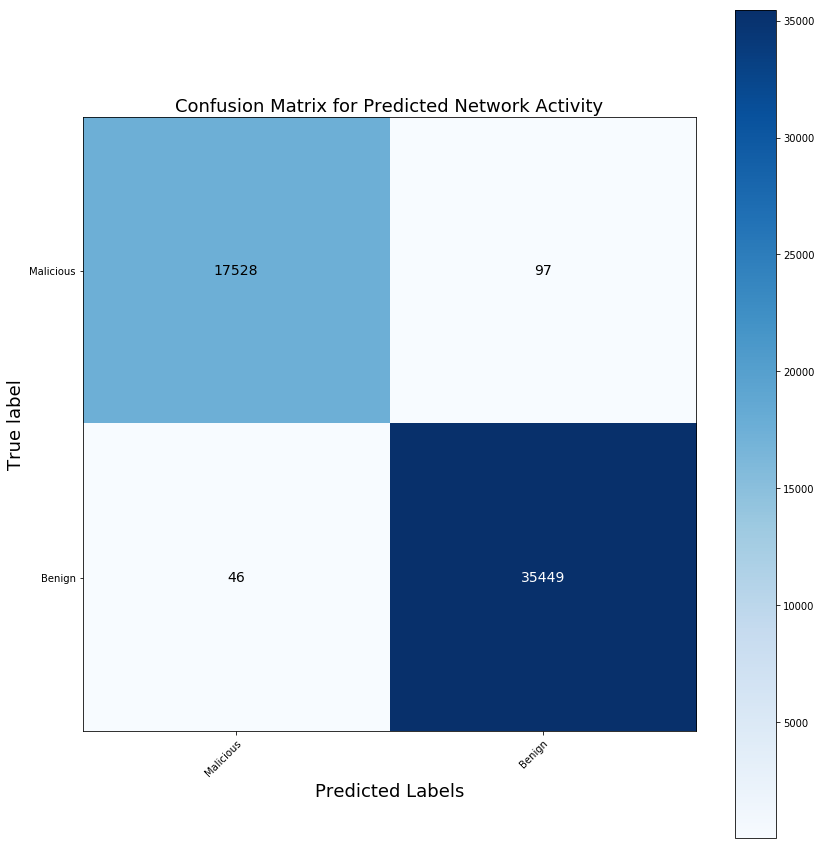

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"BINARY")

In [0]:
import math
## Train model for differentiating types of malware
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
x_coord = 0
x_coords = []
accuracies = []
current_lr = 1e-3
num_decrease = 0 
past_valid_acc = 0
go = True
with session as sess:
  first_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/simple-t-branch_1.ckpt')
  while go:
    train_acc = 0 
    for batch_num in range(int(len(mal_train_dir_X)/BATCH_SHAPE)):
      batch_meta = mal_train_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = mal_train_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      current_train_acc = fine_accuracy.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, fine_y_: batch_label})
      train_acc += current_train_acc
      if batch_num % 200 == 0:     
        x_coords.append(x_coord)
        accuracies.append(current_train_acc)
        x_coord+=1
      fine_class_train_step.run(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, fine_y_: batch_label})
    train_acc = train_acc/(int(len(mal_train_dir_X)/BATCH_SHAPE))
    print('Step %d, training accuracy %g' % (batch_num ,train_acc ))
    valid_acc = 0 
    for batch_num in range(int(len(mal_valid_dir_X)/BATCH_SHAPE)): 
      batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
      valid_acc += fine_accuracy.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, fine_y_: batch_label})
    valid_acc = valid_acc/(int(len(mal_valid_dir_X)/BATCH_SHAPE))
    print('Step %d, validation accuracy %g' % (batch_num ,valid_acc))   
    if valid_acc <= past_valid_acc:
      print(past_valid_acc)
      print(valid_acc)
      num_decrease+=1
      print("DECREASE")
    else:
      num_decrease = 0 
    if current_lr > 1e-5:
      if num_decrease == 2:
        print("DECREASE LEARNING RATE")
        current_lr = current_lr *math.sqrt(0.1)
        num_decrease = 0
    else:
      if num_decrease == 1:
        print("END")
        go = False 
    past_valid_acc = valid_acc
  print("HERE")
  second_saver.save(sess, './DP-GRAPHS/' + FOLDER+ '/simple-t-branch_1.ckpt')

Step 2575, training accuracy 0.657539
Step 137, validation accuracy 0.731658
Step 2575, training accuracy 0.7203
Step 137, validation accuracy 0.75668
Step 2575, training accuracy 0.735597
Step 137, validation accuracy 0.76704
Step 2575, training accuracy 0.743061
Step 137, validation accuracy 0.740942
0.7670403079710145
0.7409420289855072
DECREASE
Step 2575, training accuracy 0.745678
Step 137, validation accuracy 0.774457
Step 2575, training accuracy 0.750076
Step 137, validation accuracy 0.773381
0.7744565217391305
0.7733808876811594
DECREASE
Step 2575, training accuracy 0.75653
Step 137, validation accuracy 0.800894
Step 2575, training accuracy 0.759195
Step 137, validation accuracy 0.798517
0.8008944746376812
0.7985167572463768
DECREASE
Step 2575, training accuracy 0.763387
Step 137, validation accuracy 0.799083
Step 2575, training accuracy 0.766717
Step 137, validation accuracy 0.804065
Step 2575, training accuracy 0.757348
Step 137, validation accuracy 0.772588
0.804064764492753

In [0]:
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
## Get valid data for confusion matrix
with session as sess:
  second_saver.restore(sess, './DP-GRAPHS/' + FOLDER+ '/simple-t-branch_1.ckpt')
  batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
  non_adv_output = fine_logits.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, fine_y_: batch_label})
  for batch_num in range(1,int(len(mal_valid_meta_X)/BATCH_SHAPE)): 
    batch_meta = mal_valid_meta_X[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    batch_label = mal_valid_labels[batch_num*BATCH_SHAPE:batch_num*BATCH_SHAPE+BATCH_SHAPE]
    non_adv_out = fine_logits.eval(feed_dict={learning_rate:current_lr,meta_x_:batch_meta, fine_y_: batch_label})
    non_adv_output = tf.concat([non_adv_output,non_adv_out],axis=0)
  valid_cnn_labels = sess.run(non_adv_output)

In [0]:
n_valid_cnn_labels = []
n_valid_labels = []
for label in mal_valid_labels:
  n_label = np.argmax(label)
  n_valid_labels.append(n_label)
for label in valid_cnn_labels:
  n_label = np.argmax(label)
  n_valid_cnn_labels.append(n_label)
classes = ["Nsis","Geodo","Virut","Shifu","Cridex", "Tinba", "Miuref", "Zeus","Htbot","Neris"]

Confusion matrix, without normalization
[[ 566    0    6    0    1    0    0    3    0    7]
 [   2 3941    5    2    5    4    6    4   40   50]
 [  13   10 2592    3    3    3    0    8    1  556]
 [   0    9    3 1007    1    1    1    2    3    2]
 [   0    1    2    0 1608    0    0    0    0    1]
 [   0    3    0    0    2  888    0    0    0    1]
 [   2  607    1    1    2    0  705    1    8   19]
 [   1    2    6    0    0    2    0 1043    0   17]
 [   0   26    0    0    0    2    5    0  600    5]
 [  17  235  330    5    3    2    1   14   29 2607]]


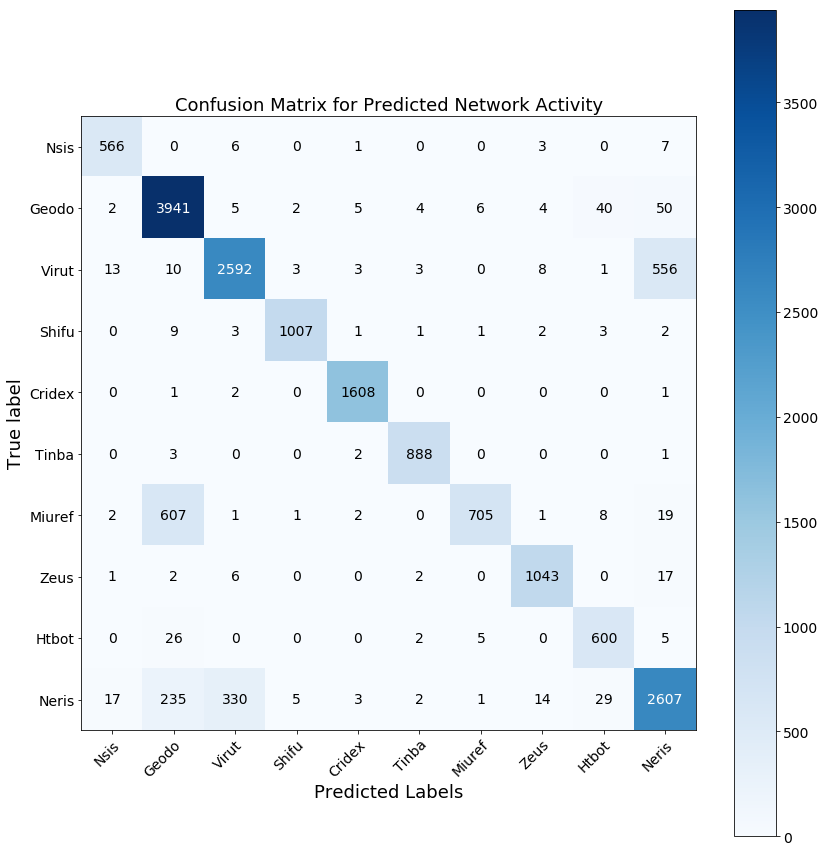

In [0]:
plot_confusion_matrix(n_valid_labels,n_valid_cnn_labels,classes,"SIMPLE-MAL")